## Description:
这个是sharedBottom模型的demo, 尝试在中级API的基础上，加一些loss优化的思路， 这次是UML, 尝试下batch级别的更新， 因为epoch级别的更新太慢了实在是

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, DenseFeat
from deepctr.feature_column import get_feature_names
from SharedBottom import SharedBottom

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True      # TensorFlow按需分配显存
config.gpu_options.per_process_gpu_memory_fraction = 0.5  # 指定显存分配比例
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# tf.config.experimental_run_functions_eagerly(True)

DeepCTR version 0.9.0 detected. Your version is 0.8.2.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.9.0


In [2]:
data_path = '../data_process'
data = pd.read_csv(os.path.join(data_path, 'train_data.csv'), index_col=0, parse_dates=['expo_time'])

In [3]:
# 选择出需要用到的列
use_cols = ['user_id', 'article_id', 'expo_time', 'net_status', 'exop_position', 'duration', 'device', 'city', 'age', 'gender', 'img_num', 'cat_1', 'click']
data_new = data[use_cols]

In [4]:
# 由于这个data_new的数据量还是太大， 我电脑训练不动， 所以这里再进行一波抽样
users = set(data_new['user_id'])
sampled_users = random.sample(users, 1000)
data_new = data_new[data_new['user_id'].isin(sampled_users)]

## 数据预处理

In [5]:
# 处理img_num
def transform(x):
    if x == '上海':
        return 0
    elif isinstance(x, float):
        return float(x)
    else:
        return float(eval(x))
data_new['img_num'] = data_new['img_num'].apply(lambda x: transform(x))

In [6]:
user_id_raw = data_new[['user_id']].drop_duplicates('user_id')
doc_id_raw = data_new[['article_id']].drop_duplicates('article_id')

# 简单数据预处理
sparse_features = [
    'user_id', 'article_id', 'net_status', 'exop_position', 'device', 'city', 'age', 'gender', 'cat_1'
]
dense_features = [
    'img_num'
]

# 填充缺失值
data_new[sparse_features] = data_new[sparse_features].fillna('-1')
data_new[dense_features] = data_new[dense_features].fillna(0)

# 归一化
mms = MinMaxScaler(feature_range=(0, 1))
data_new[dense_features] = mms.fit_transform(data_new[dense_features])

feature_max_idx = {}
for feat in sparse_features:
    lbe = LabelEncoder()
    data_new[feat] = lbe.fit_transform(data_new[feat])
    feature_max_idx[feat] = data_new[feat].max() + 1000

# 构建用户id词典和doc的id词典，方便从用户idx找到原始的id
# user_id_enc = data[['user_id']].drop_duplicates('user_id')
# doc_id_enc = data[['article_id']].drop_duplicates('article_id')
# user_idx_2_rawid = dict(zip(user_id_enc['user_id'], user_id_raw['user_id']))
# doc_idx_2_rawid = dict(zip(doc_id_enc['article_id'], doc_id_raw['article_id']))

In [7]:
# 划分数据集  这里按照曝光时间划分
train_data = data_new[data_new['expo_time'] < '2021-07-03']
test_data = data_new[data_new['expo_time'] >= '2021-07-06']

## 特征封装

In [8]:
sparse_feature_columns = [SparseFeat(feat, feature_max_idx[feat], embedding_dim=4) for feat in sparse_features]
Dense_feature_columns = [DenseFeat(feat, 1) for feat in dense_features]

In [9]:
# 划分dnn和linear特征
dnn_features_columns = sparse_feature_columns + Dense_feature_columns
lhuc_feature_columns = sparse_feature_columns

In [10]:
feature_names = get_feature_names(dnn_features_columns)

In [11]:
# AttributeError: 'numpy.dtype[int64]' object has no attribute 'base_dtype' 
# Keras需要把输入声明为Keras张量，其他的比如numpy张量作为输入不好使
train_model_input = {name: tf.keras.backend.constant(train_data[name]) for name in feature_names}
test_model_input = {name: tf.keras.backend.constant(test_data[name]) for name in feature_names}

## 模型搭建

In [12]:
model = SharedBottom(dnn_features_columns, lhuc_feature_columns, tower_dnn_hidden_units=[], task_types=['regression', 'binary'], 
             task_names=['duration', 'click'])

In [13]:
#model.summary()

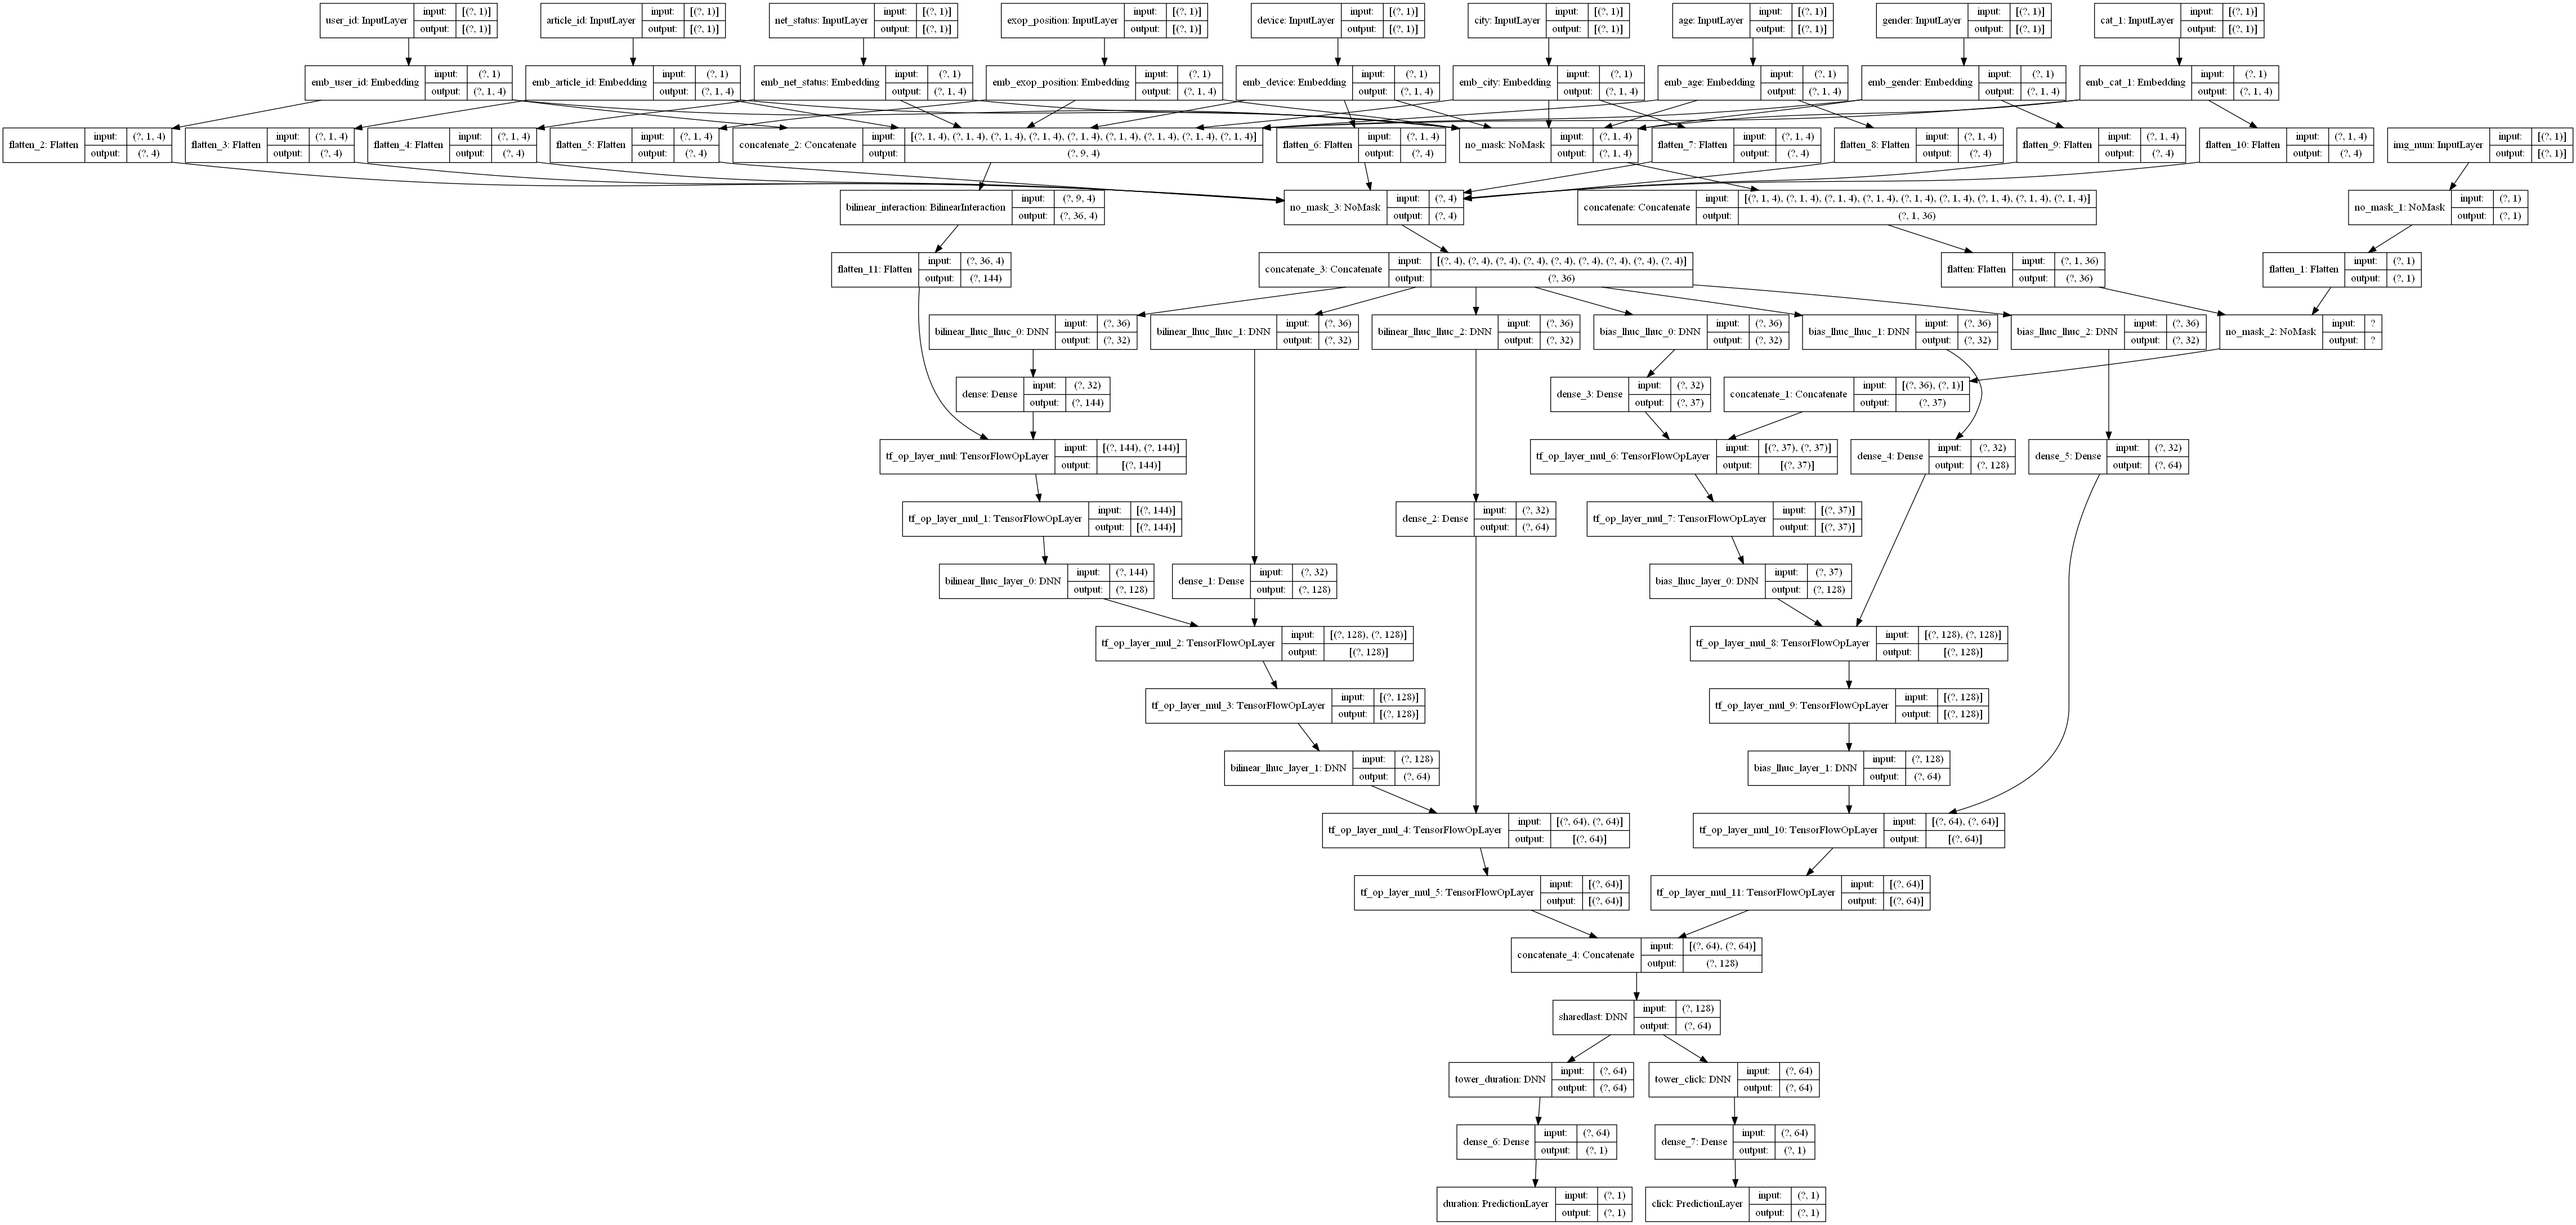

In [16]:
# 绘制模型结构  
# GraphViz's executables not found  
# 安装软件，配置环境变量即可  https://graphviz.org/download/
# from tensorflow import keras
# keras.utils.plot_model(model, to_file='./shared_bottom.png', show_shapes=True)

## 模型的训练和预测

In [13]:
label_duration = tf.keras.backend.constant(train_data['duration'].values)
label_click = tf.keras.backend.constant(train_data['click'].values)

In [14]:
# 构建数据管道
train_ds = tf.data.Dataset.from_tensor_slices((train_model_input, (label_duration, label_click))).shuffle(buffer_size=100).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
# 模型训练这里，需要用到底层的训练脚本，这里不能用高层keras的API
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_reg_loss = tf.keras.metrics.Mean(name='train_reg_loss')
train_bin_loss = tf.keras.metrics.Mean(name='train_bin_loss')
loss_func = {"binary": tf.keras.losses.binary_crossentropy, "regression": tf.keras.losses.mean_squared_error}

In [18]:
@tf.function
def train_step(features, labels, task_types, weight):
    losses = []
    gnorms = []
    
    # RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes
    # 这是因为GradientTape 占用的资源默认情况下dw = t.gradient(loss, w)计算完毕就会立即释放
    # 如果连续计算微分， 指定persistent=True
    with tf.GradientTape() as tape:
        # 遍历每个任务
        for i, task_type in enumerate(task_types):
            out = model(features, training=True)
            task_loss = loss_func[task_types[i]](out[i], labels[i])
            # print("task_loss", task_loss)
            if task_types[i] == "regression":
                losses.append(tf.math.exp(-1 * weight[i]) * task_loss + weight[i])
            elif task_types[i] == "binary":
                losses.append(2 * tf.math.exp(-1 * weight[i]) * task_loss + weight[i])
                
        # 这里更新
        loss = tf.add_n(losses)
        gradients = tape.gradient(loss, model.trainable_variables+weight)
        
    # 更新所有W参数
    optimizer.apply_gradients(zip(gradients, model.trainable_variables+weight))
    
    train_loss(loss)
    train_reg_loss(losses[0])
    train_bin_loss(losses[1])
    
    return loss, losses[0], losses[1]

In [19]:
epochs = 10
best_test_loss = float('inf')
task_types = ["regression", "binary"]

task_weight = [tf.Variable(0.0, trainable=True), tf.Variable(0.0, trainable=True)]

for epoch in tqdm(range(1, epochs+1)):
    
    print(task_weight)
    train_loss.reset_states()
    train_reg_loss.reset_states()
    train_bin_loss.reset_states()

    for feature, labels in train_ds:
        loss, loss_reg, loss_bin = train_step(feature, labels, task_types, task_weight)
    
    template = 'Epoch {}, Loss: {} - regression_loss: {} - binary_loss: {}'
    print(template.format(epoch, train_loss.result(), 
                          np.mean(loss_reg), 
                         np.mean(loss_bin)))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>]


 10%|████████▎                                                                          | 1/10 [00:23<03:27, 23.06s/it]

Epoch 1, Loss: 3656.44482421875 - regression_loss: 3585.334228515625 - binary_loss: 4.572315216064453
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.2664813>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.1531729>]


 20%|████████████████▌                                                                  | 2/10 [00:34<02:08, 16.07s/it]

Epoch 2, Loss: 1372.8096923828125 - regression_loss: 887.9437255859375 - binary_loss: 3.5430376529693604
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9886438>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4710748>]


 30%|████████████████████████▉                                                          | 3/10 [00:45<01:36, 13.84s/it]

Epoch 3, Loss: 731.9453735351562 - regression_loss: 504.0931396484375 - binary_loss: 3.213604688644409
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.5234106>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5433208>]


 40%|█████████████████████████████████▏                                                 | 4/10 [00:56<01:17, 12.87s/it]

Epoch 4, Loss: 451.97845458984375 - regression_loss: 212.77584838867188 - binary_loss: 3.333538770675659
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.957873>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5541266>]


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:08<01:01, 12.29s/it]

Epoch 5, Loss: 303.62811279296875 - regression_loss: 278.0236511230469 - binary_loss: 3.078141689300537
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.3310957>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5563298>]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:19<00:47, 11.90s/it]

Epoch 6, Loss: 215.18104553222656 - regression_loss: 117.82759857177734 - binary_loss: 3.8394031524658203
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.6637785>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5561142>]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:30<00:35, 11.70s/it]

Epoch 7, Loss: 158.26101684570312 - regression_loss: 37.43160629272461 - binary_loss: 3.2052252292633057
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.9683378>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5559872>]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:41<00:23, 11.54s/it]

Epoch 8, Loss: 119.8019027709961 - regression_loss: 171.4287567138672 - binary_loss: 3.965940475463867
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.252534>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5562787>]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:53<00:11, 11.51s/it]

Epoch 9, Loss: 92.68128204345703 - regression_loss: 43.93475341796875 - binary_loss: 2.697626829147339
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.5217977>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5568497>]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:04<00:00, 12.43s/it]

Epoch 10, Loss: 73.07829284667969 - regression_loss: 50.505523681640625 - binary_loss: 3.33186936378479


In [20]:
pred_ans = model.predict(test_model_input, batch_size=256)

In [21]:
print("test click AUC", round(roc_auc_score(test_data['click'], pred_ans[1]), 4))

test click AUC 0.4915


In [22]:
print("test duration", round(mean_absolute_error(test_data['duration'], pred_ans[0]), 4))

test duration 35.124
